In [ ]:
import matplotlib.pyplot as plt
from spacepy import pycdf
import numpy as np
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.axis import Axis
from matplotlib import colors
import matplotlib.ticker as mticker
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LogNorm
from matplotlib.pyplot import cm
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
from scipy.special import voigt_profile
import scipy.stats as st

c:\Users\franc\anaconda3\Lib\site-packages\spacepy\time.py:2341: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [ ]:
class stereo_lab:
    
    def __init__(self, date, start_event, end_event, filepath):
        self.date = date
        self.start_event = start_event
        self.end_event = end_event
        self.filepath = filepath
    
    @staticmethod
    def to_timestamp(array): # Converts datetime arrays into timestamp arrays
        timestamps = list(map(lambda x: datetime.timestamp(x), array))
        return timestamps
    @staticmethod
    def to_date(array): # Converts timestamp arrays into datetime arrays
        mydates = list(map(lambda x: datetime.fromtimestamp(x), array))
        return mydates
    @staticmethod
    def halfpeak_avg(a):
        peak_condition = np.where(a >= 0.8*np.max(a))
        peak_arr = a[peak_condition]
        return np.average(peak_arr)
    @staticmethod
    def halfpeak_err(a):
        peak_condition = np.where(a >= 0.8*np.max(a))
        peak_arr = a[peak_condition]
        return np.std(peak_arr)
    
    def data(self):
        cdf_file = pycdf.CDF(self.filepath)
        freq, flux, time = cdf_file['frequency_lfr_auto_averages_ch0_V1V2'][...][0]/1000, np.transpose(cdf_file['psp_fld_l3_rfs_lfr_PSD_SFU'][...]), cdf_file['epoch_lfr_auto_averages_ch0_V1V2'][...]
        #freq, flux, time = cdf_file['frequency'][...][0]/1000, np.transpose(cdf_file['psd_sfu'][...]), cdf_file['epoch'][...]
        
        yyyy, mm, dd = self.date.split('-')
        HH_s, MM_s, SS_s = self.start_event.split(':')
        HH_e, MM_e, SS_e = self.end_event.split(':')
        time_start = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_s), int(MM_s), int(SS_s))
        time_end = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_e), int(MM_e), int(SS_e))
        
        def time_inter(t_arr):
            start = np.abs(np.array(t_arr)-datetime.timestamp(time_start)).argmin()
            end = np.abs(np.array(t_arr)-datetime.timestamp(time_end)).argmin()
            return [start, end]
        
        def time_back(t_arr):
            start = np.abs(np.array(t_arr)-datetime.timestamp(time_start)).argmin()
            end = np.abs(np.array(t_arr)-datetime.timestamp(time_start) - 600).argmin()
            return [start, end]
        
        back_start = time_back(self.to_timestamp(time))[0]
        back_end = time_back(self.to_timestamp(time))[1]
        flux_back = np.median(flux[:, back_start:back_end], axis=1)
        
        start = time_inter(self.to_timestamp(time))[0]
        end = time_inter(self.to_timestamp(time))[1]
        
        num = len(flux[0, start:end])
        background = np.transpose(np.tile(flux_back, (num, 1)))
        flux_2d = flux[:, start:end] - background
        flux_2d = np.where(flux_2d <=np.average(background)/100, np.average(background)/100, flux_2d)
        #flux_2d = np.max(flux_2d)*(flux_2d - np.min(flux_2d))/(np.max(flux_2d) - np.min(flux_2d)) + np.average(background)/10
        
        my_dict = {'time': time[start:end], 'freq': freq, 'flux': flux_2d, 'background': background}
        
        return my_dict
        
    def dyn_spec(self, show, save, max_f, min_f, theta_0):
        
        d = stereo_lab(self.date, self.start_event, self.end_event, self.filepath)
        flux, time, freq = d.data()['flux'], d.data()['time'], d.data()['freq']
        t_correct = time[0].timestamp()
        time_resolution = np.min(np.ediff1d(self.to_timestamp(time)))/2
        
        def arg_peak(a, b):
            peak_condition = np.where(a >= 0.95*np.max(a))
            peak_arr = np.array(b)[peak_condition]
            unc = (np.max(peak_arr) - np.min(peak_arr))/2
            return unc
        
        def arg_midpeak(a):
            peak_condition = np.where(a >= 0.95*np.max(a))
            peak_arg = (np.max(peak_condition) + np.min(peak_condition))/2
            return int(peak_arg)
        
        def sig_correct(a):
            for i in range(1,len(a)):
                if a[i] <= time_resolution:
                    a[i] = time_resolution
            return a
        
        max_flux = list(map(lambda i: time[arg_midpeak(flux[i])], range(0, len(freq))))
        
        HH_s, MM_s, SS_s = self.start_event.split(':')
        HH_e, MM_e, SS_e = self.end_event.split(':')
        
        freq_range = np.where((freq<=max_f)&(freq>=min_f))
        ts = np.array([t.timestamp() for t in max_flux])
        #t_1MHZ = ts[np.where(freq == 1013.6719)] - t_correct
        
        #t_res = freq[freq_range]/freq[freq_range] * np.min(np.ediff1d(self.to_timestamp(time)))/2
        t_res = sig_correct(np.array(list(map(lambda i: arg_peak(flux[i,:],  self.to_timestamp(time)), range(0, len(freq))))))[freq_range]      
        #t_res = np.ediff1d(ts[freq_range], to_end=np.ediff1d(ts[freq_range])[-1])/2
        plt.figure(figsize=(8,4))
        plt.plot(freq[freq_range], t_res)
        
        def freq_model(r):
            return 8.9*np.sqrt(4.8e9/(r**14) + 3e8/(r**6) + 1.4e6/(r**2.3))
        
        def n_0(r):
            return 4.8e9/(r**14) + 3e8/(r**6) + 1.4e6/(r**2.3)
        
        def t(f, A, B, C):
            T = (f/(1000*B))**(-1/A) + C
            #B = t_1MHZ - C
            #T = B*(f/1000)**A + C
            return T
        
        i1 = freq_range[0][0]
        i2 = freq_range[0][-1]+2
        
        max_flux_freq = list(map(lambda i: freq[flux[:,i].argmax()], range(0, len(time))))
        ts_freq = np.array([t.timestamp() for t in time])
        min_f_res=min_f
        max_f_res=max_f
        freq_range_res = np.where((freq<=max_f_res)&(freq>=min_f_res))
        
        '''plt.scatter(max_flux_freq, np.abs(np.ediff1d(max_flux_freq, to_end=[1])/np.ediff1d(ts_freq, to_end=[1])), c='b', s=10)
        plt.scatter(freq, np.abs(np.ediff1d(freq, to_end=[1])/np.ediff1d(ts, to_end=[1])), c='r', s=10)
        plt.plot(freq, np.ediff1d(freq, to_end=[1])/t_res, 'g')
        print('resolution check', np.abs(np.ediff1d(freq[freq_range_res], to_end=[1])/np.ediff1d(ts[freq_range_res], to_end=[1])) <= np.ediff1d(freq[freq_range_res], to_end=[1])/t_res)
        #plt.ylim(-5, 5)
        plt.xlim(min_f_res, max_f_res)'''
        
        myFmt = mdates.DateFormatter('%H:%M')
        
        fig = plt.figure(figsize=(34,18))
        
        ax_grid = fig.add_gridspec(2, 1, hspace=0.3, height_ratios=[1, 1])
        
        ax_0 = ax_grid[0].subgridspec(1, 2,  wspace=0.08, width_ratios=[1.6, 1.4])
        ax_0_a = ax_0[0].subgridspec(1, 1, width_ratios=[1])
        ax_0_b = ax_0[1].subgridspec(1, 2, wspace=0.06, width_ratios=[2.5,0.5])
        
        ax_1 = ax_grid[1].subgridspec(1, 3, wspace=0.3, width_ratios=[1, 1, 1])
        
        ax0a = [fig.add_subplot(ax_0_a[0, 0])]
        ax0b = [fig.add_subplot(ax_0_b[0, 0]), fig.add_subplot(ax_0_b[0, 1])]
        ax1 = [fig.add_subplot(ax_1[0, 0]), fig.add_subplot(ax_1[0, 1]), fig.add_subplot(ax_1[0, 2])]
        
        ax_spectro, ax_res, ax_r, ax_vc, ax_vc_r, ax_ac = ax0a[0], ax0b[1], ax0b[0], ax1[0], ax1[1], ax1[2]
        
        flux = np.where(flux<=0, np.min(np.abs(flux[np.isfinite(flux)])), flux)
        Spectrum = np.max(flux)*(flux - np.min(flux))/(np.max(flux) - np.min(flux)) + 0.1
        v_min_val, v_max_val =  np.min(Spectrum) + 3000, (np.max(Spectrum) + np.min(Spectrum))/2
    
        T,F = np.meshgrid(time, freq)
        im = ax_spectro.pcolormesh(T, F, flux, norm=colors.LogNorm(vmin=v_min_val , vmax=v_max_val), cmap=cm.inferno)

        cbar = fig.colorbar(im)
        cbar.ax.tick_params(labelsize=21)
        cbar.set_label('PSP (SFU)', fontsize=30)
        
        ax_spectro.scatter(max_flux, freq, s=100, c='g', marker='x', label='Maximum Flux')
        ax_spectro.xaxis.set_major_formatter(myFmt)
        ax_spectro.tick_params(axis='both', which='both', labelsize=21, length=5, width=1)
        ax_spectro.set_ylim(200, np.max(freq))
        ax_spectro.set_yscale("log")
        ax_spectro.set_ylabel('Frequency (kHz)', fontsize=30)
        ax_spectro.set_title(self.date + ' (yyyy-mm-dd)', fontsize=30, pad=20)

        if show == 'show':
            
            ax_spectro.set_xlabel('Time (HH:MM)', fontsize=30)
            
            #t_res = np.ediff1d(ts[freq_range], to_end=7)
            sig_dt = t_res
            guess_par = [1, 194, 700]
            parameters, covariance = curve_fit(t, freq[freq_range], ts[freq_range] - t_correct, sigma=sig_dt, p0=guess_par, absolute_sigma=True, maxfev=200000)
            
            f_fit = freq[freq_range]
            t_fit_result = np.int64(t(freq[freq_range], *parameters)) + np.int64(t_correct)
            t_fit = self.to_date([t for t in t_fit_result])
            
            ax_spectro.plot(t_fit, f_fit, 'g', linestyle='--', linewidth=2.5) #, label=r'f[MHz] = $\frac{' + str('%.2e' % (parameters[2])) + ' \pm ' + str('%.2e' % np.sqrt(covariance[2,2])) + '}{(t[s] - t_{0})^{' + str('%.2e' % parameters[0]) + ' \pm ' + str('%.2e' % np.sqrt(covariance[0,0])) + '}}$')        
            ax_spectro.hlines(np.max(f_fit), datetime.fromtimestamp(np.min(ts[freq_range])), datetime.fromtimestamp(np.max(ts[freq_range])), 'g', linestyle='--', linewidth=2.5)
            ax_spectro.hlines(np.min(f_fit), datetime.fromtimestamp(np.min(ts[freq_range])), datetime.fromtimestamp(np.max(ts[freq_range])), 'g', linestyle='--', linewidth=2.5)
            ax_spectro.vlines(datetime.fromtimestamp(np.min(ts[freq_range])), np.min(f_fit), np.max(f_fit),'g', linestyle='--', linewidth=2.5)
            ax_spectro.vlines(datetime.fromtimestamp(np.max(ts[freq_range])), np.min(f_fit), np.max(f_fit),'g', linestyle='--', linewidth=2.5)
            #ax_spectro.vlines(datetime.fromtimestamp(t_correct + parameters[2]), np.min(freq[freq_range]), np.max(freq[freq_range]),'g', linestyle='--', linewidth=2.5)
                
            r = np.linspace(2, 215, 1000)
            dist = np.interp(freq[freq_range], np.sort(freq_model(r)), r[np.argsort(freq_model(r))])
            dist_h = np.interp(0.5*freq[freq_range], np.sort(freq_model(r)), r[np.argsort(freq_model(r))])
            t_to_fit = ts[freq_range]
            
            def gradient(x,y):
                z = np.ediff1d(x, to_end=(x[-1]-x[-2]))/np.ediff1d(y, to_end=(y[-1]-y[-2]))
                return z

            def sum_err(a):
                N = len(a)
                return np.sqrt(np.sum(a**2))/N
            
            def t_r_fit(r, a, b, c):
                #c = 1/(1-b)
                #t_r = (r**(1-b) - 1 / (1-b))/a + c
                t_r = (r**(1-b) / (1-b) - c)/a
                return t_r
            p = 3

            r_to_c = 7/3
            t_k = 7*(dist-np.min(dist))/3
            t_k_h = 7*(dist_h-np.min(dist_h))/3
            t_0 = 7*(dist-np.min(dist))*np.cos(np.pi*theta_0/180)/3
            t_0_h = 7*(dist_h-np.min(dist_h))*np.cos(np.pi*theta_0/180)/3
            
            def my_density(r):
                return 1.4e6/(r**2.3)
            
            dr = np.sqrt((1.4e6**(1/2.3) * (1/2.3) * my_density(dist)**(-3.3/2.3) * 2*freq[freq_range]/(8.9**2) * np.ediff1d(np.array(freq)[i1:i2]))**2 + (1.4e6**(1/2.3) * (1/2.3) * my_density(dist)**(-3.3/2.3) * 0.*my_density(dist))**2)
            dr_h = np.sqrt((1.4e6**(1/2.3) * (1/2.3) * my_density(dist_h)**(-3.3/2.3) * 0.5*freq[freq_range]/(8.9**2) * np.ediff1d(np.array(freq)[i1:i2]))**2 + (1.4e6**(1/2.3) * (1/2.3) * my_density(dist_h)**(-3.3/2.3) * 0.*my_density(dist_h))**2)
            
            guess = [0.05, -0.30, 1200]
            bounds = [[-3/7, -np.inf, -np.inf], [3/7, np.inf, np.inf]]
            
            '''f_MHz = freq[freq_range]/1000
            dTdA, dTdB = (f_MHz/parameters[1])**(-1/parameters[0]) * np.log(f_MHz/parameters[1]) / parameters[0]**2, parameters[1]**(-1 + 1/parameters[0]) / (parameters[0] * f_MHz**(1/parameters[0]))
            print('dT', dTdA, dTdB)
            print('params', parameters)
            print('covs', np.sqrt(covariance))
            sig_dt = np.sqrt(dTdA**2*covariance[0,0] + dTdB**2*covariance[1,1] + covariance[2,2])*f_MHz/f_MHz
            '''
            
            perr = np.sqrt(np.diag(covariance))
            perr[2], parameters[2] = 0, 0
            sig_dt = np.sqrt(t_res**2 + perr[2]**2) *dist/dist
            print('sig_dt, perr', sig_dt, perr[2])
            
            params_k, covars_k = curve_fit(t_r_fit, dist, t_to_fit - t_correct - t_k[::-1] - parameters[2], method='trf', sigma=sig_dt, p0=guess, bounds=bounds, absolute_sigma=True, maxfev=200000)
            params_k_h, covars_k_h = curve_fit(t_r_fit, dist_h, t_to_fit  - t_correct - t_k_h[::-1] - parameters[2], method='trf', sigma=sig_dt, p0=guess, bounds=bounds, absolute_sigma=True, maxfev=200000)
            params, covars = curve_fit(t_r_fit, dist, t_to_fit - t_correct - t_0[::-1] - parameters[2], method='trf', sigma=sig_dt, p0=guess, bounds=bounds, absolute_sigma=True, maxfev=200000)
            params_h, covars_h = curve_fit(t_r_fit, dist_h, t_to_fit  - t_correct - t_0_h[::-1] - parameters[2], method='trf', sigma=sig_dt, p0=guess, bounds=bounds, absolute_sigma=True, maxfev=200000)
            
            res = t_to_fit - t_correct - t_0[::-1] - parameters[2] - t_r_fit(dist, *params)
            res_h = t_to_fit  - t_correct - t_0_h[::-1] - parameters[2] - t_r_fit(dist_h, *params_h)
            
            chisq = np.sum((res/sig_dt)**2)/(len(dist) - p)
            chisq_h = np.sum((res_h/sig_dt)**2)/(len(dist) - p)
            
            '''def cs(n, y):
                return st.chisquare(n, np.sum(n)/np.sum(y) * y)
            
            chisq, pvalue = cs(t_to_fit - t_correct - t_0[::-1] - parameters[2], t_r_fit(dist, *params))
            chisq = chisq/(len(ts[freq_range]) - 2)'''
            
            A, B, A_err, B_err = params[0], params[1], np.sqrt(covars[0,0]), np.sqrt(covars[1,1])
            A_h, B_h, A_err_h, B_err_h = params_h[0], params_h[1], np.sqrt(covars_h[0,0]), np.sqrt(covars_h[1,1])
            print(np.sqrt(covars[2,2]))
            
            def V_func(r, a, b, c):
                v = r_to_c*a*r**b
                return v
            
            def dVdt_func(r, a, b, c):
                v = (7e5)*b*a**2*r**(2*b-1)
                return v
            
            c = 3e5
            V_uncorr, dVdT_uncorr = V_func(dist, *params_k), dVdt_func(dist, *params_k)
            V_uncorr_h, dVdT_uncorr_h = V_func(dist_h, *params_k_h), dVdt_func(dist_h, *params_k_h)
            V, dVdT = V_func(dist, *params), dVdt_func(dist, *params)
            V_h, dVdT_h = V_func(dist_h, *params_h), dVdt_func(dist_h, *params_h)
            
            '''V = correct*V_uncorr
            V_h = correct_h*V_uncorr_h
            
            dVdT = B*c**2 * 7e5*A*r_f**B / ((7e5*A*r_f*7e5*r_f**B) * (np.cos(np.pi*theta_0/180) + c/(7e5*A*r_f**B))**2 )
            dVdT_h = B_h*c**2 * 7e5*A_h*r_h**B_h / ((7e5*A_h*r_h*7e5*r_h**B_h) * (np.cos(np.pi*theta_0/180) + c/(7e5*A_h*r_h**B_h))**2 )
            '''
            
            vel_err = r_to_c*np.sqrt((dist**(B)*A_err)**2 + (A*np.log(dist)*dist**B*B_err)**2)
            vel_err_h = r_to_c*np.sqrt((dist_h**(B)*A_err_h)**2 + (A_h*np.log(dist_h)*dist_h**B_h*B_err_h)**2)
            
            acc_err =  (7e5)*np.sqrt((2*A*B*dist**(2*B-1))**2*covars[0,0] + (2*np.log(dist)*dist**(2*B-1)*B*A**2 + dist**(2*B-1)*A**2)**2*covars[1,1])
            acc_err_h = (7e5)*np.sqrt((2*A_h*B_h*dist_h**(2*B_h-1))**2*covars_h[0,0]  + (2*np.log(dist_h)*dist_h**(2*B_h-1)*B_h*A_h**2 + dist_h**(2*B_h-1)*A_h**2)**2*covars_h[1,1])
            
            velocity, velocity_h = np.average(V[np.isfinite(V)]), np.average(V_h[np.isfinite(V_h)])
            velocity_err, velocity_err_h = sum_err(vel_err[np.isfinite(vel_err)]), sum_err(vel_err_h[np.isfinite(vel_err_h)])
            
            acceleration, acceleration_h = np.median(dVdT[np.isfinite(dVdT)]), np.median(dVdT_h[np.isfinite(dVdT_h)])
            acceleration_err, acceleration_err_h = 1.25*sum_err(acc_err[np.isfinite(acc_err)]), 1.25*sum_err(acc_err_h[np.isfinite(acc_err_h)])

            ax_vc.plot(V, freq_model(dist), color='b',linewidth=3, markersize=6)
            ax_vc.plot(V_h, freq_model(dist_h), color='r',linewidth=3, markersize=6)
                      
            f = mticker.ScalarFormatter(useMathText=True)
            f.set_powerlimits((-3,3))

            def v_fit(w,a,b):
                v = a*w**b
                return v
            
            def v_fit_h(w,a,b):
                v = a*w**b
                return v
            
            w_pe = 2*np.pi*freq[freq_range]
            cov_f = np.zeros((2,2))
            cov_h = np.zeros((2,2))
            par_f, cov_f[1,1], cov_f[0,0] = [A*(1.4*(2*np.pi*8.9)**2)**(B/2.3), -2*B/2.3], (2*B_err/2.3)**2, (A_err*(1.4*(2*np.pi*8.9)**2)**(B/2.3))**2
            par_h, cov_h[1,1],cov_h[0,0] = [A_h*(1.4*(2*np.pi*8.9)**2)**(B_h/2.3), -2*B_h/2.3], (2*B_err_h/2.3)**2, (A_err_h*(1.4*(2*np.pi*8.9)**2)**(B/2.3))**2
            handles_v, labels_v = ax_vc.get_legend_handles_labels()
            line_v_r = Line2D([0], [0], label=r'v$_H^{fit}$ = (' + '${}$'.format(f.format_data(round(par_h[0],3))) + ' $\pm$ ' + '${}$'.format(f.format_data(round(np.sqrt(cov_h[0,0]),3)))  + ') $ \omega_{pe}^{'+ str('%.2f' % (par_h[1])) +'\pm'+ str('%.2f' % (np.sqrt(cov_h[1,1]))) + '}$', color='r')
            line_v_b = Line2D([0], [0], label=r'v$_F^{fit}$ = (' + '${}$'.format(f.format_data(round(par_f[0],3))) + ' $\pm$ ' + '${}$'.format(f.format_data(round(np.sqrt(cov_f[0,0]),4))) + ') $ \omega_{pe}^{'+ str('%.2f' % (par_f[1])) +'\pm'+ str('%.2f' % (np.sqrt(cov_f[1,1]))) + '}$', color='b')
            handles_v.extend([line_v_b, line_v_r])
            ax_vc.legend(handles=handles_v, fontsize=21, loc='lower left', frameon=False, ncol=1)
            ax_vc.tick_params(axis='both', which='both', labelsize=21, length=5, width=1)
            ax_vc.set_ylabel('Frequency (kHz)', fontsize=30)
            ax_vc.set_xlabel('v/c', fontsize=30)
            tick_avg = np.around(velocity, 1)
            ax_vc.set_yscale("log")
            lim2, lim1 = 0.8*np.min(freq_model(dist_h)), 2.3*np.max(freq_model(dist))#800, 100 
            ax_vc.set_ylim(lim1, lim2)
            ax_vc.set_xlim(0, 1.5*max(V_h))
            ax_vc_r.plot(V, dist, color='b',linewidth=3, markersize=6, label=r'v$_F^{fit}$ = (' + '${}$'.format(f.format_data(round(A,3))) + ' $\pm$ ' + '${}$'.format(f.format_data(round(A_err,3))) + ') $r^{'+ str('%.2f' % (B)) + '\pm' + str('%.2f' % (B_err)) + '}$')
            ax_vc_r.plot(V_h, dist_h, color='r',linewidth=3, markersize=6, label=r'v$_H^{fit}$ =' + '${}$'.format(f.format_data(round(A_h,3))) + ' $\pm$ ' + '${}$'.format(f.format_data(round(A_err_h,3))) + ') $r^{'+ str('%.2f' % (B_h)) + '\pm' + str('%.2f' % (B_err_h)) + '}$')

            ax_vc_r.tick_params(axis='both', which='both', labelsize=21, length=5, width=1)
            ax_vc_r.set_ylabel('Heliocentric Distance ($R_s$)', fontsize=30)
            ax_vc_r.set_xlabel('v/c', fontsize=30)
            tick_avg = np.around(velocity, 1)
            ax_vc_r.set_yscale("log")
            x_init_r = np.interp(lim1, np.sort(freq_model(r)), r[np.argsort(freq_model(r))])
            x_fin_r = np.interp(lim2, np.sort(freq_model(r)), r[np.argsort(freq_model(r))])
            ax_vc_r.set_ylim(x_init_r,x_fin_r)
            ax_vc_r.set_xlim(0, 1.5*max(V_h))
            ax_vc_r.legend(loc='lower left', fontsize=21, frameon=False, ncol=1)

            ax_ac.plot(dVdT, dist, color='b',linewidth=3, markersize=6)
            ax_ac.plot(dVdT_h, dist_h, color='r',linewidth=3, markersize=6)
            
            ax_ac.tick_params(axis='both', which='both', labelsize=21, length=5, width=1)
            ax_ac.set_xlabel(r'a [km s$^{-2}$]', fontsize=30)
            ax_ac.set_yscale("log")
            ax_ac.set_ylim(x_init_r,x_fin_r)
            ax_ac.legend(loc='upper left', fontsize=21, frameon=False, ncol=1)
            #ax_ac.set_ylabel('Heliocentric Distance ($R_s$)', fontsize=30)
            
            ax_r.plot(self.to_date(np.int64(t_r_fit(dist, *params)) + np.int64(t_correct + t_0[::-1] + parameters[2])), dist, color='b',linewidth=3, markersize=6, label=r'$\chi_F^2$ = ' + '${}$'.format(f.format_data(round(chisq,3))))
            ax_r.plot(self.to_date(np.int64(t_r_fit(dist_h, *params_h)) + np.int64(t_correct + t_0_h[::-1] + parameters[2])), dist_h, color='r',linewidth=3, markersize=6, label=r'$\chi_H^2$ = ' + '${}$'.format(f.format_data(round(chisq_h,3))))
            ax_r.scatter(self.to_date(t_to_fit), dist, marker='x', c='b', s=100)
            ax_r.scatter(self.to_date(t_to_fit), dist_h, marker='x', c='r', s=100)
            ax_r.errorbar(self.to_date(t_to_fit), dist, xerr=[timedelta(seconds=t) for t in sig_dt], fmt='none', ecolor='b', elinewidth=1)
            ax_r.errorbar(self.to_date(t_to_fit), dist_h, xerr=[timedelta(seconds=t) for t in sig_dt], fmt='none', ecolor='r', elinewidth=1)
            ax_r.xaxis.set_major_formatter(myFmt)
            
            '''ax_r.plot(np.int64(t_r_fit(dist, *params)) + np.int64(t_correct + t_0[::-1] + parameters[2]), dist, color='b',linewidth=3, markersize=6, label=r'$\chi_F^2$ = ' + '${}$'.format(f.format_data(round(chisq,3))))
            ax_r.plot(np.int64(t_r_fit(dist_h, *params_h)) + np.int64(t_correct + t_0_h[::-1] + parameters[2]), dist_h, color='r',linewidth=3, markersize=6, label=r'$\chi_H^2$ = ' + '${}$'.format(f.format_data(round(chisq_h,3))))
            ax_r.errorbar(t_to_fit, dist, xerr=sig_dt, ecolor='b', marker='x', fmt='o')
            ax_r.errorbar(t_to_fit, dist_h, xerr=sig_dt, ecolor='r', marker='x', fmt='o')'''
            
            ax_r.set_ylim(x_init_r,x_fin_r)
            ax_r.set_xlabel('Time (HH:MM)', fontsize=30)
            ax_r.set_ylabel('Heliocentric Distance ($R_s$)', fontsize=30)
            ax_r.tick_params(axis='both', which='both', labelsize=21, length=5, width=1)
            #ax_r.tick_params(axis='x', labelrotation=45)
            ax_r.legend(loc='upper left', fontsize=21, frameon=False, ncol=1)
            
            ax_res.step(res/np.sqrt(np.sum(res**2)/(len(res)-p)), dist, color='b', linewidth=3)
            ax_res.step(res/np.sqrt(np.sum(res_h**2)/(len(res)-p)), dist_h, color='r', linewidth=3)
            ax_res.tick_params(axis='both', which='both', labelleft=False, labelsize=21, length=5, width=1)
            #ax_res.set_yscale("log")
            ax_res.set_ylim(x_init_r,x_fin_r)
            ax_res.set_xlim(-3, 3)
            ax_res.set_xlabel('Norm. Res.', fontsize=30)
            
        else:
            ax_vc.set_visible(False)
            ax_vc_r.set_visible(False)
            ax_ac.set_visible(False)
            ax_r.set_visible(False)
            ax_res.set_visible(False)
            
        
        if save == 'Y':
                plt.savefig("psp/dynspec/psp_hfr_dynspec_" + self.date + '_' + HH_s + '_' + HH_e + ".png", bbox_inches='tight')
            
            
        elif save == 'A':
            plt.savefig("psp/dynspec/psp_hfr_dynspec_" + self.date + '_' + HH_s + '_' + HH_e + ".png", bbox_inches='tight')
        
            np.savetxt("data_velocity/psp/dist/psp_hfr_dist_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", dist)
            np.savetxt("data_velocity/psp/dist/psp_hfr_dist_h_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", dist_h)
            np.savetxt("data_velocity/psp/velocity/psp_hfr_V_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", V)
            np.savetxt("data_velocity/psp/velocity/psp_hfr_V_h_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", V_h)
            np.savetxt("data_velocity/psp/velocity/psp_hfr_V_uncorr_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", V_uncorr)
            np.savetxt("data_velocity/psp/velocity/psp_hfr_V_uncorr_h_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", V_uncorr_h)
            np.savetxt("data_velocity/psp/acceleration/psp_hfr_dvdt_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", dVdT)
            np.savetxt("data_velocity/psp/acceleration/psp_hfr_dvdt_h_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", dVdT_h)
            np.savetxt("data_velocity/psp/acceleration/psp_hfr_dvdt_uncorr_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", dVdT_uncorr)
            np.savetxt("data_velocity/psp/acceleration/psp_hfr_dvdt_uncorr_h_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", dVdT_uncorr_h)
            np.savetxt("data_velocity/psp/vel_err/psp_hfr_vel_err_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", vel_err)
            np.savetxt("data_velocity/psp/vel_err/psp_hfr_vel_err_h_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", vel_err_h)
            np.savetxt("data_velocity/psp/acc_err/psp_hfr_dvdt_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", acc_err)
            np.savetxt("data_velocity/psp/acc_err/psp_hfr_dvdt_h_" + self.date + '_' + HH_s + '_' + HH_e+ ".txt", acc_err_h)
        
        elif save == 'T':
            
            print('Freq drift rate check', np.ediff1d(freq)/t_res)
            print('time res variation max, min', np.max(np.ediff1d(self.to_timestamp(time))), np.min(np.ediff1d(self.to_timestamp(time))))
            print('dv/v', vel_err/V_uncorr)
            print('parameters', *parameters)
            print('time fit', type(t(freq[freq_range], *parameters)[0]), type(ts[freq_range][0]))
            print('time fit (ts)', ts[freq_range])
            print('Time resolution: ', t_res)
            print('All Frequencies', freq) 
            print('the maximum is:', npz.max(list(map(lambda x: np.interp(1000, freq, flux[:,x]), list(range(len(time)))))))
            print('distances:', dist)
            print('The timesteps are: ', np.ediff1d(ts[freq_range]))
            print('frequencies (range):', freq[freq_range])
            print('frequency resolution (range):', np.ediff1d(freq[freq_range]))
            print('correction (t_0, t_k, t_uncorrected)', t_0[::-1], t_k[::-1], ts[freq_range] - t_correct)
            print('chisq values ', chisq, chisq_h)
            print('F: A, B, A_err, B_err', A, B, A_err, B_err)
            print('H: A, B, A_err, B_err', A_h, B_h, A_err_h, B_err_h)
            print('resolution check', np.abs(np.ediff1d(freq[freq_range_res], to_end=[1])/np.ediff1d(ts[freq_range_res], to_end=[1])) <= np.ediff1d(freq[freq_range_res], to_end=[1])/t_res)
            print('da/a', acc_err/dVdT)
        

In [ ]:
date_list = ['2020-07-11',   '2020-06-05']
start_list = ['02:10:00',     '09:25:00']
end_list = ['02:50:00',      '10:00:00']
path_list = ['20200711_v03', '20200605_v03']

Data 3


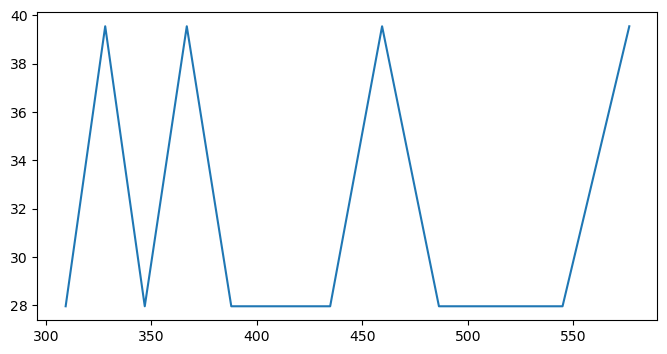

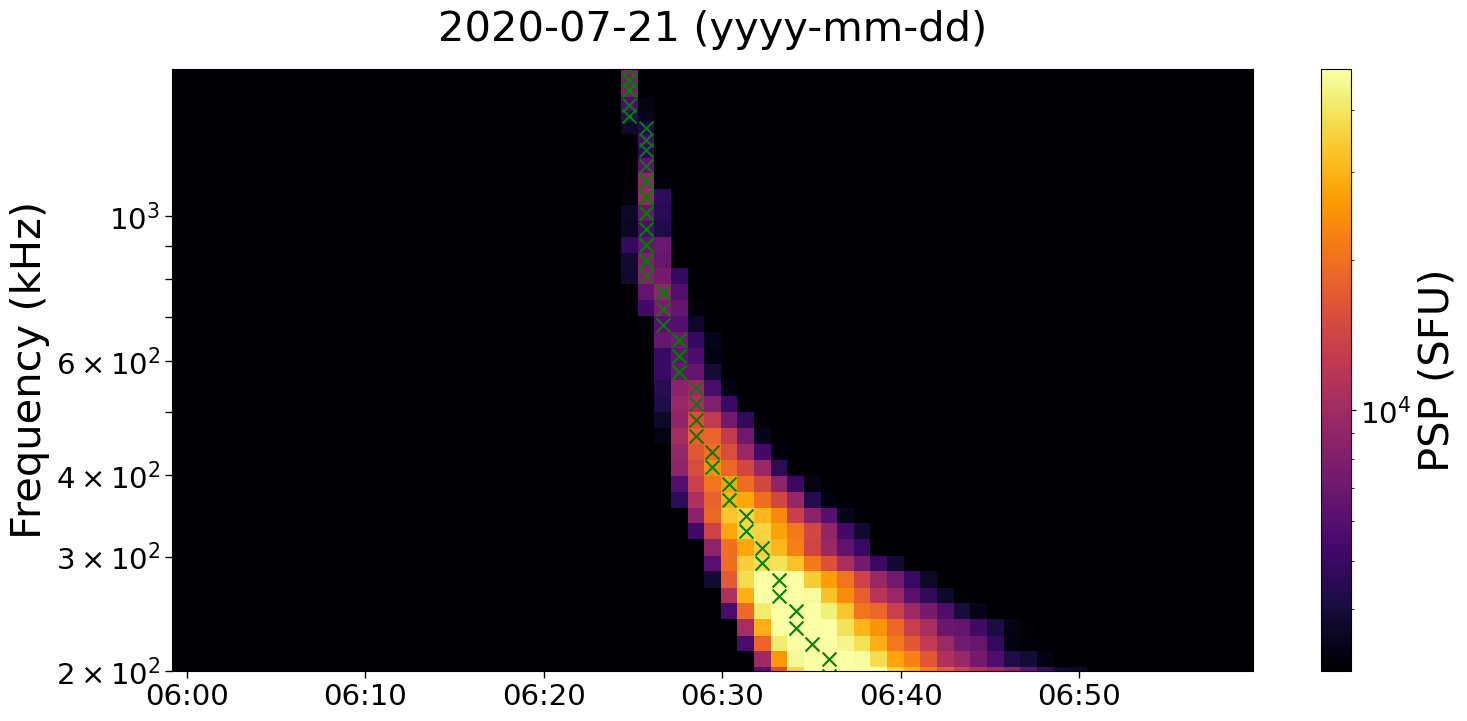

In [5]:
l=[3]
a = [140]
f_i = [600]
f_f = [300]
for d in range(len(l)):
    #try:    
    stereo_lab(date_list[l[d]], start_list[l[d]], end_list[l[d]], 'psp\\psp_fld_l3_rfs_lfr_' + path_list[l[d]]).dyn_spec('sho', 'Y', f_i[d], f_f[d], a[d]) #1400, 450
    print('Data', l[d])
    #except:
        #pass
    break

C:\Users\franc\AppData\Local\Temp\ipykernel_24328\2554075134.py:121: RuntimeWarning: invalid value encountered in power
  T = (f/(1000*B))**(-1/A) + C


sig_dt, perr [ 1.69299293  8.73828149  6.99060106  8.73815954 15.72863805  8.73815954
  1.69299293  1.69299293  1.69299293  8.73815906  1.74768054  1.69299293
  1.69299293  1.69299293  1.69299293  3.49536157  3.49536157  1.69299293
  6.99047852] 0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


73.16755623418278
Data 0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sig_dt, perr [ 3.4952395  10.48584104 27.96216154  3.49536145  3.46801794 17.47632003
 13.98108101  6.99060154  6.99060154  6.99047899 13.98095846  6.99060106
 17.47632051  3.46801794  3.4952395   6.99047899  3.4952395   3.46801794
  3.49523997  6.99060094 10.48584044] 0.0
40.156393458028774
Data 1


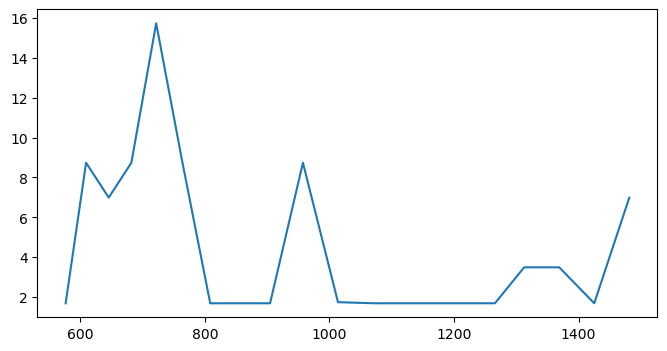

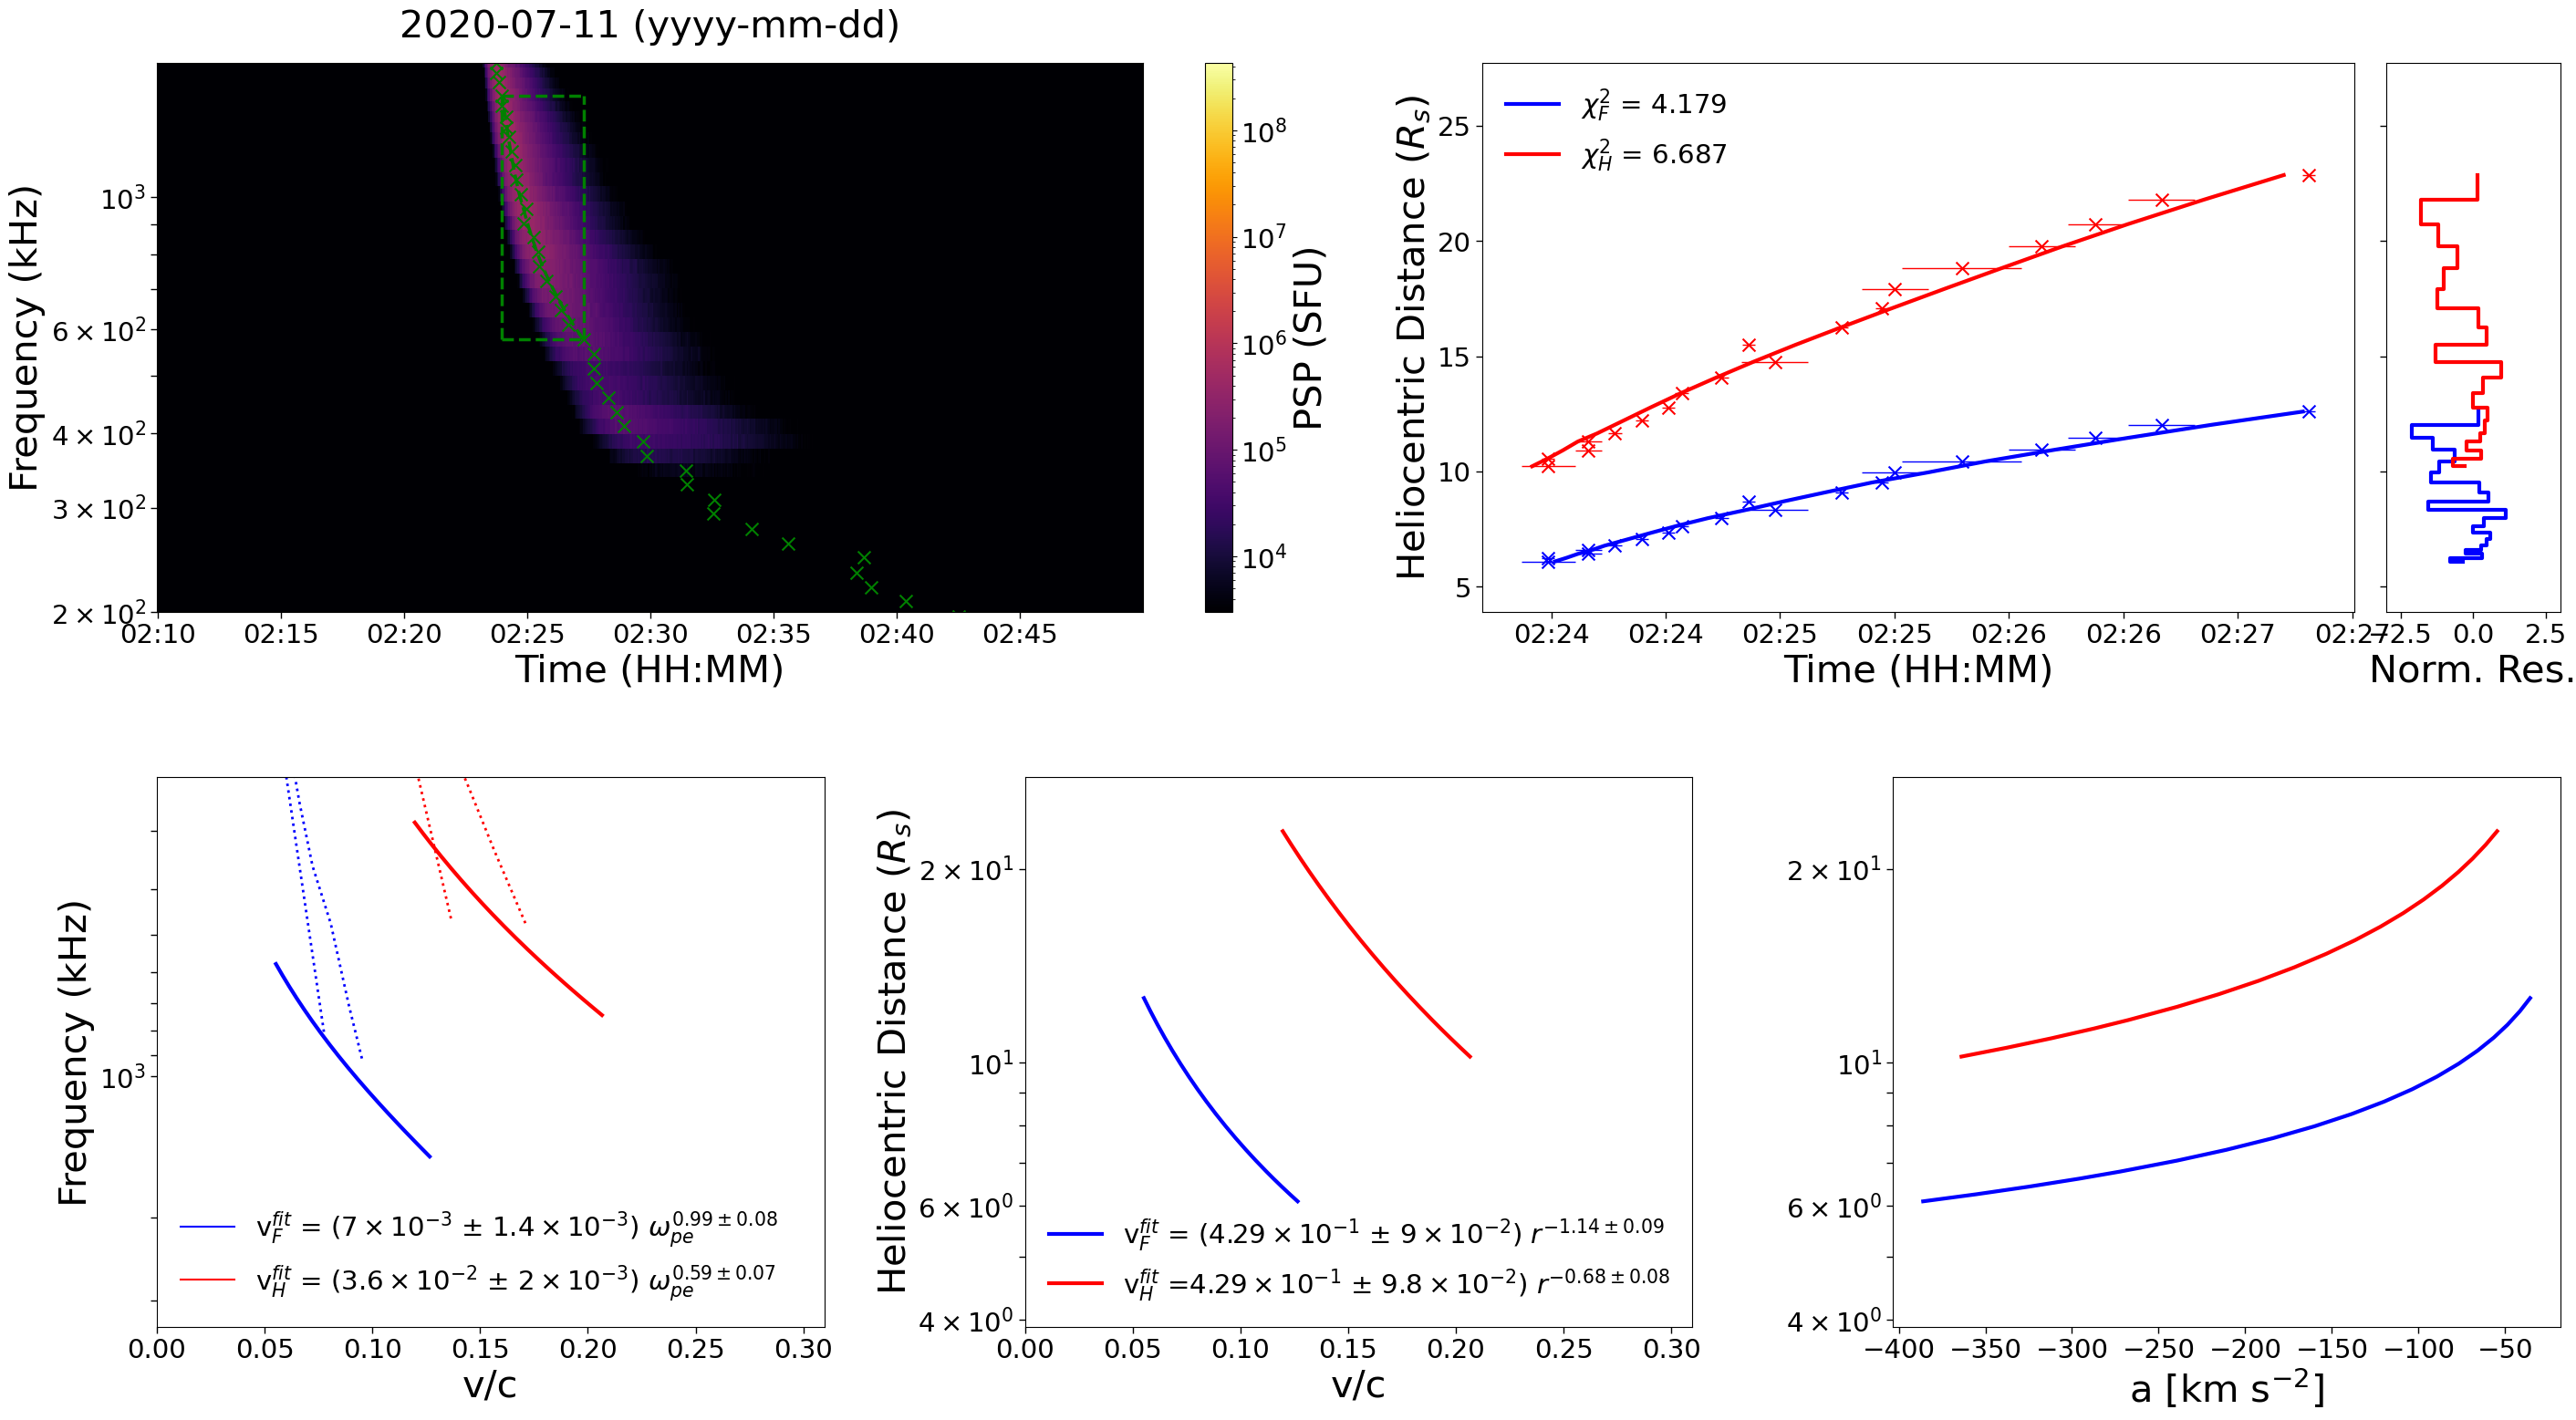

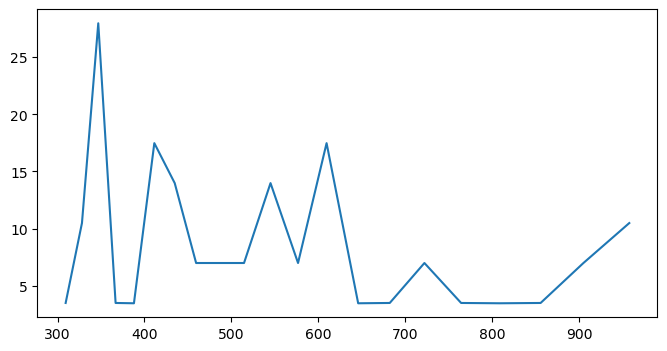

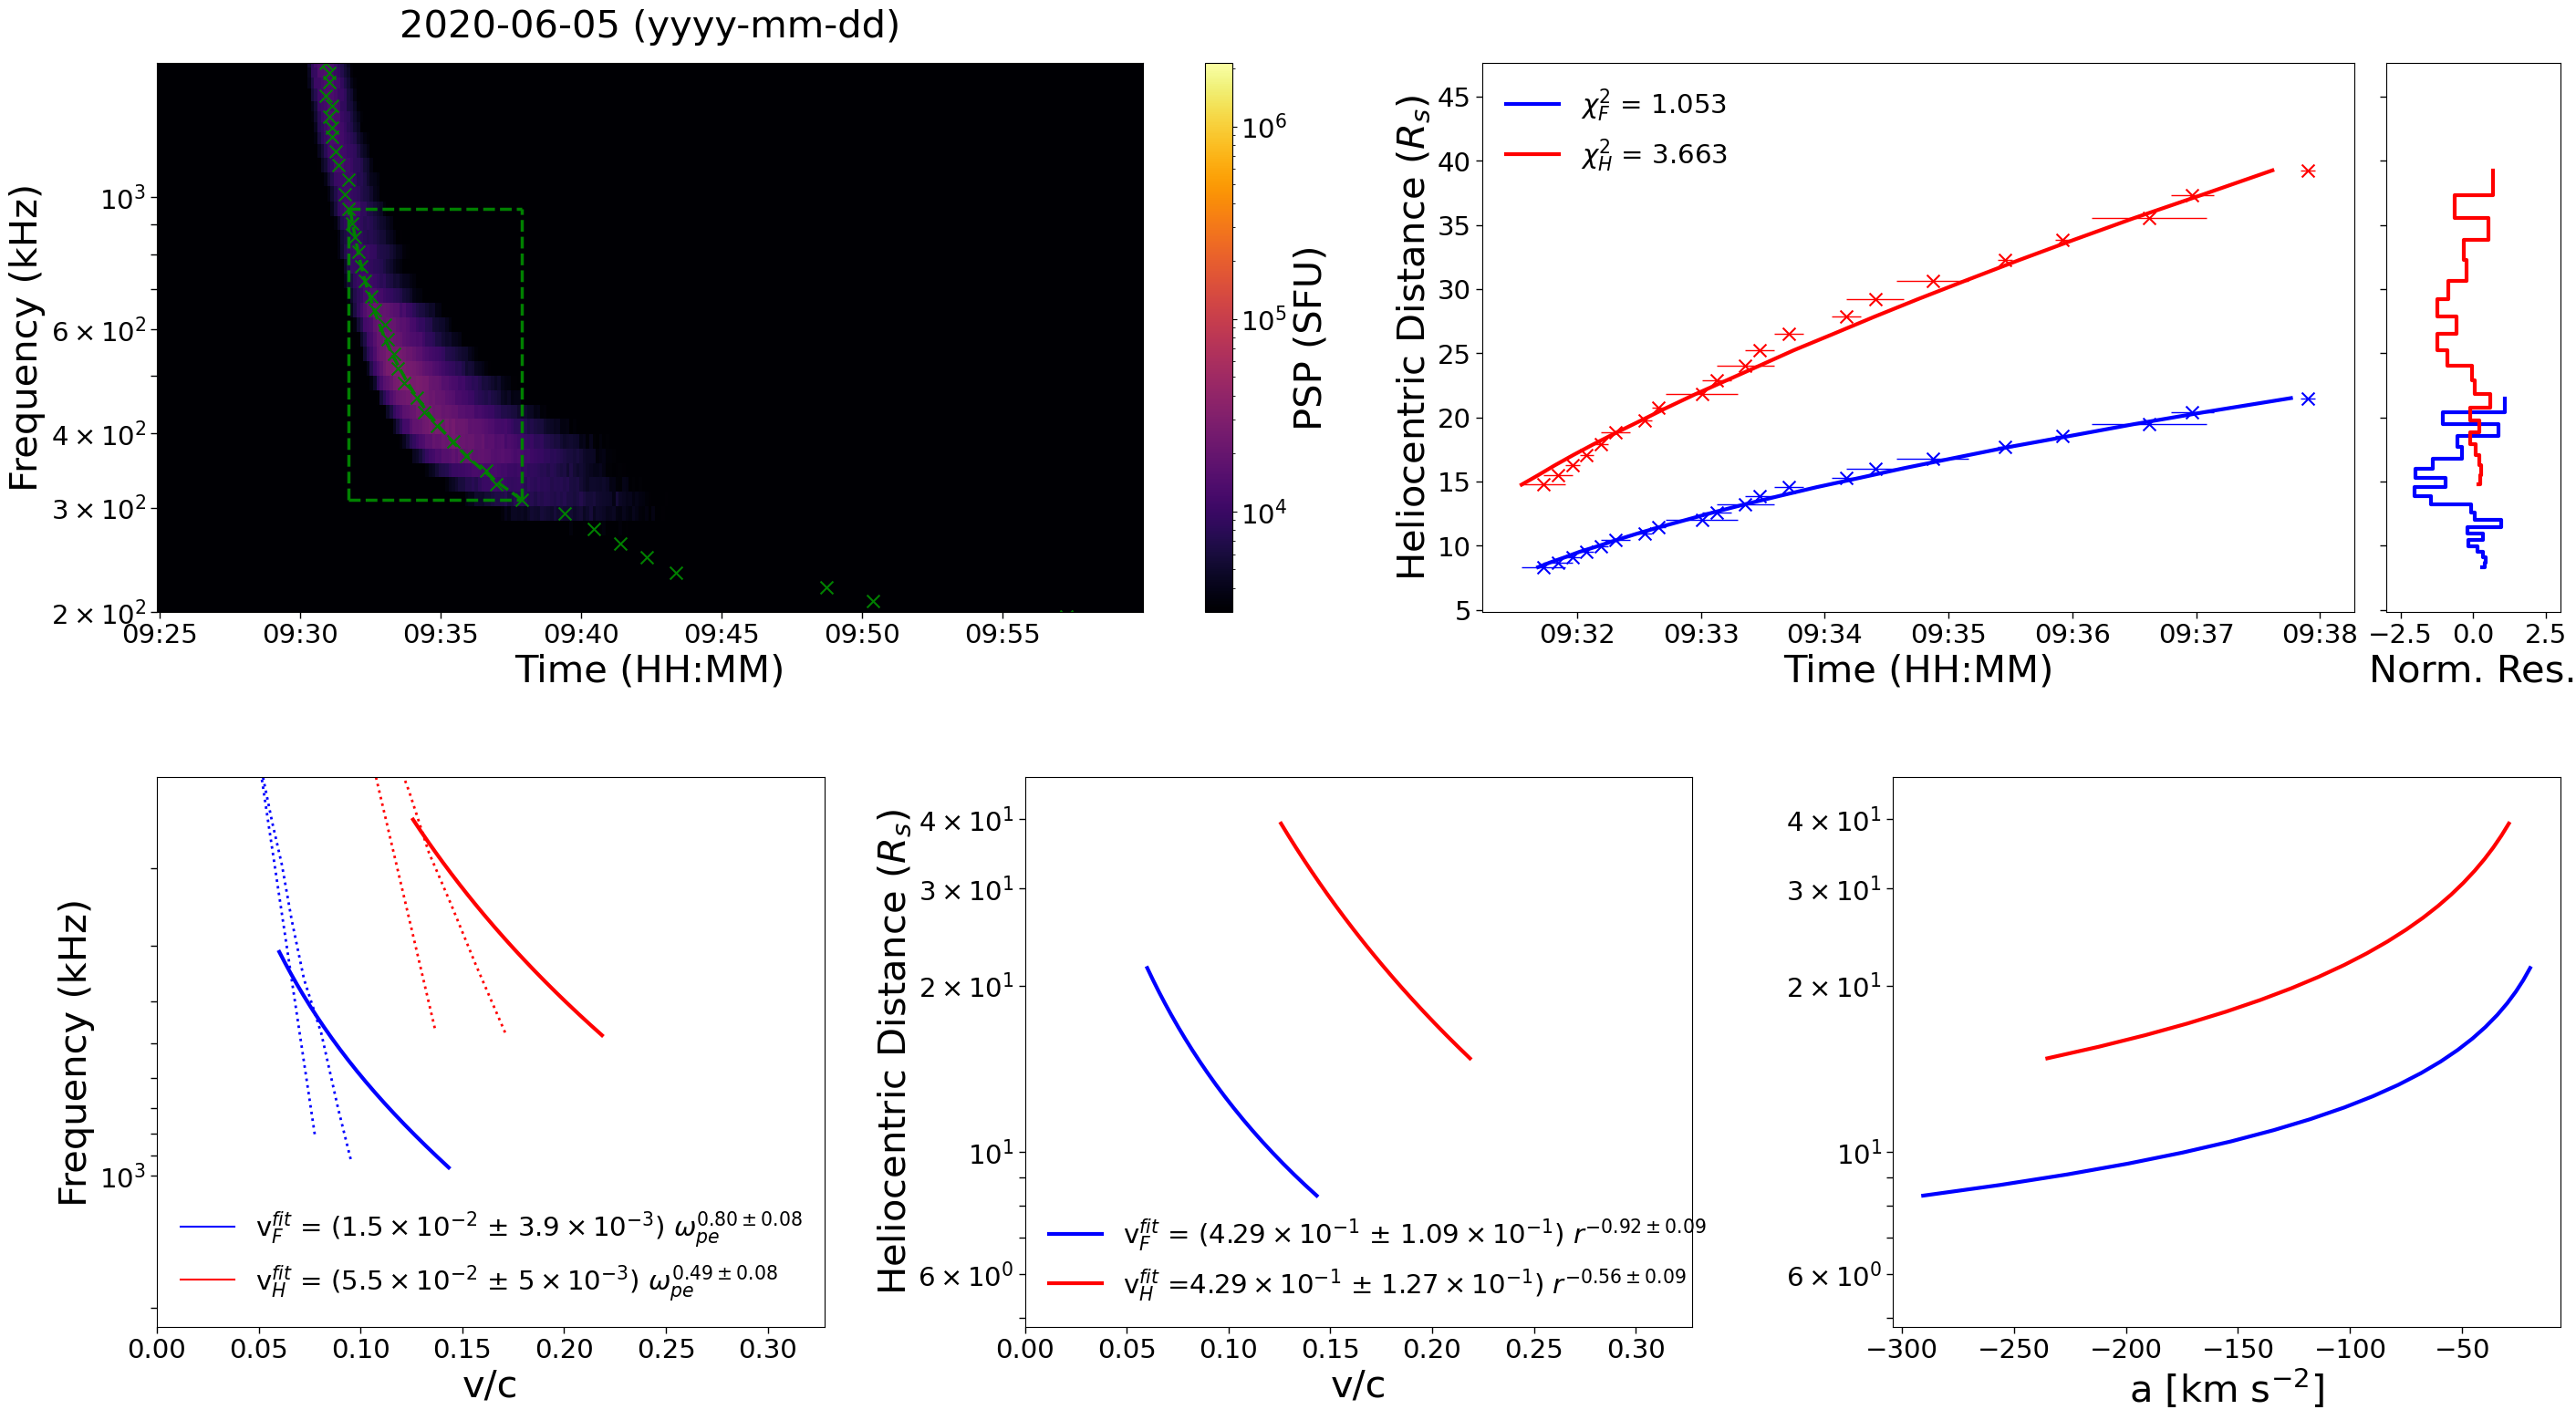

In [ ]:

l=[0,1]
a = [90, 90]
f_i = [1500, 1000]
f_f = [575, 300]
#angles: 90, 90
for d in range(len(l)):
    #try:    
    stereo_lab(date_list[l[d]], start_list[l[d]], end_list[l[d]], 'psp\\psp_fld_l3_rfs_lfr_' + path_list[l[d]]).dyn_spec('show', 'A', f_i[d], f_f[d], a[d])
    print('Data', l[d])
    #except:
        #pass
    #break